In [1]:
import mrcfile

import numpy as np
import matplotlib.pyplot as plt

import fsc_utils as fsc

In [2]:
cmap_a = [plt.get_cmap('tab20c').colors[idx] for idx in [0, 4, 8, 12]]
cmap_b = [plt.get_cmap('tab20c').colors[idx] for idx in [2, 6, 10, 12]]

In [3]:
# You will need the 3-D volume and mask from: https://www.ebi.ac.uk/emdb/EMD-11657

map_file = ''
mask_file = ''

with mrcfile.open(map_file) as mrc:
    x = mrc.data
    voxel = mrc.voxel_size.x 
    mrc.close()

with mrcfile.open(mask_file) as mrc:
    mask = mrc.data
    mrc.close() 
    
x = np.sum(x * mask, axis=2)

r = x.shape[0] // 2

freq = fsc.get_radial_spatial_frequencies(x, voxel, mode='full')
split_freq = fsc.get_radial_spatial_frequencies(x, voxel, mode='split')

In [4]:
### Phase shift correction ###

np.random.seed(0)

snr = 1e5
B_signal = 150
B_noise = 0

y1, eps1 = fsc.generate_noisy_data(x, voxel, snr, B_signal, B_noise, return_noise=True)
y2, eps2 = fsc.generate_noisy_data(x, voxel, snr, B_signal, B_noise, return_noise=True)

fsc_y1y2 = fsc.two_image_frc(y1, y2, r)

s1 = y1[:, ::2]
s2 = y1[:, 1::2]
s2_shift = fsc.ift2(fsc.phase_shift_2d(fsc.ft2(s2), 0.5, 0))

s3 = y1[::2]
s4 = y1[1::2]
s4_shift = fsc.ift2(fsc.phase_shift_2d(fsc.ft2(s4), 0, 0.5))

sfsc_1 = fsc.two_image_frc(s1, s2, r)
sfsc_2 = fsc.two_image_frc(s3, s4, r)
sfsc_avg = np.mean([sfsc_1, sfsc_2], axis=0)

sfsc_shift_1 = fsc.two_image_frc(s1, s2_shift, r)
sfsc_shift_2 = fsc.two_image_frc(s3, s4_shift, r)
sfsc_shift_avg = np.mean([sfsc_shift_1, sfsc_shift_2], axis=0)

shift = np.array([0, 0.5])

J0 = fsc.zero_order_bessel(freq, shift, voxel, mode='split')

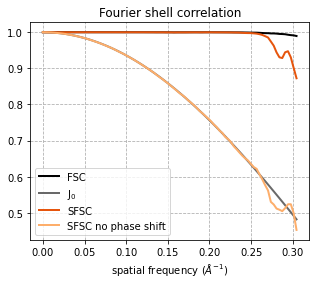

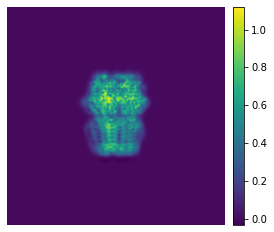

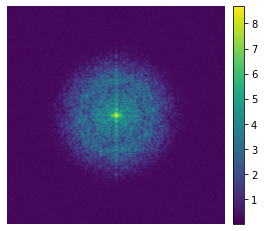

In [5]:
plt.figure(figsize=(5,4))
plt.plot(freq[:r//2], fsc_y1y2[:r//2], color='k', linestyle='-', linewidth=2, label='FSC')
plt.plot(freq[:r//2], J0[:r//2], color='dimgray', linestyle='-', linewidth=2, label=r'J$_0$')
plt.plot(freq[:r//2], sfsc_shift_avg[:r//2], color=cmap_a[1], linewidth=2, label='SFSC')
plt.plot(freq[:r//2], sfsc_avg[:r//2], color=cmap_b[1], linewidth=2, label='SFSC no phase shift')
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('legend', fontsize=10)
plt.grid(which='major', linestyle='--')
plt.xlabel('spatial frequency 'r'(${\AA}^{-1}$)')
plt.title('Fourier shell correlation')
plt.legend()
# plt.savefig('')
plt.show()

plt.figure(figsize=(5,4))
plt.imshow(y1)
plt.axis('off')
plt.colorbar(pad=0.03)
# plt.savefig('')
plt.show()

plt.figure(figsize=(5,4))
plt.imshow(fsc.log_abs(fsc.ft2(y1)))
plt.axis('off')
plt.colorbar(pad=0.03)
# plt.savefig('')
plt.show()

In [6]:
### Correct variance scaling ###

np.random.seed(0)

snr = 15
B_signal = 100
B_noise = 0

y1, eps1 = fsc.generate_noisy_data(x, voxel, snr, B_signal, B_noise, return_noise=True)
y2, eps2 = fsc.generate_noisy_data(x, voxel, snr, B_signal, B_noise, return_noise=True)

fsc_y1y2 = fsc.two_image_frc(y1, y2, r)

sfsc = np.mean(fsc.single_image_frc(y1, r), axis=0)
sfsc_adjusted = 2*sfsc / (1 + sfsc)

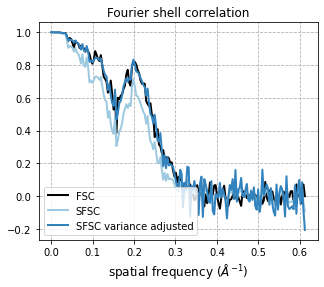

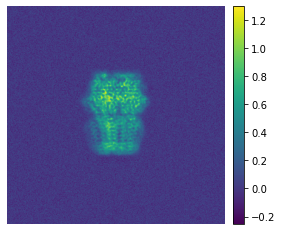

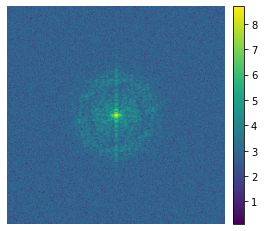

In [7]:
plt.figure(figsize=(5,4))
plt.plot(freq, fsc_y1y2, color='k', linestyle='-', linewidth=2, label='FSC')
plt.plot(freq, sfsc, color=cmap_b[0], linewidth=2, label='SFSC')
plt.plot(freq, sfsc_adjusted, color=cmap_a[0], linewidth=2, label='SFSC variance adjusted')
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('legend', fontsize=10)
plt.grid(which='major', linestyle='--')
plt.xlabel('spatial frequency 'r'(${\AA}^{-1}$)')
plt.title('Fourier shell correlation')
plt.legend(loc='lower left')
# plt.savefig('')
plt.show()

plt.figure(figsize=(5,4))
plt.imshow(y1)
plt.axis('off')
plt.colorbar(pad=0.03)
# plt.savefig('')
plt.show()

plt.figure(figsize=(5,4))
plt.imshow(fsc.log_abs(fsc.ft2(y1)))
plt.axis('off')
plt.colorbar(pad=0.03)
# plt.savefig('')
plt.show()

In [8]:
### Noise whitening correction ###

np.random.seed(0)

snr = 15
B_signal = 100
B_noise = 50

y1, eps1 = fsc.generate_noisy_data(x, voxel, snr, B_signal, B_noise, return_noise=True)
y2, eps2 = fsc.generate_noisy_data(x, voxel, snr, B_signal, B_noise, return_noise=True)

fsc_y1y2 = fsc.two_image_frc(y1, y2, r)

r_corner = int(np.ceil(np.sqrt(np.sum([s**2 for s in y1.shape]))/2))

sfsc = np.mean(fsc.single_image_frc(y1, r), axis=0)
sfsc_adjusted = 2*sfsc / (1 + sfsc)

y1_whiten = fsc.whitening_transform(y1, eps1, r_corner)

sfsc_whiten = np.mean(fsc.single_image_frc(y1_whiten, r), axis=0)
sfsc_whiten_adjusted = 2*sfsc_whiten / (1 + sfsc_whiten)

# # These are also approximately equivalent ways to estimate the FSC
# ps_w = fsc.compute_spherically_averaged_power_spectrum(y1_whiten, r)
# fsc_from_ps = (ps_w - 1) / ps_w  # from equation 15
# ps_eps = fsc.compute_spherically_averaged_power_spectrum(eps1, r)
# ps_y = fsc.compute_spherically_averaged_power_spectrum(y1, r)
# ssnr = (ps_y - ps_eps) / ps_eps  # from equation 35
# fsc_from_ssnr = ssnr / (1 + ssnr)

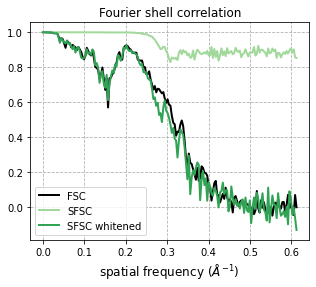

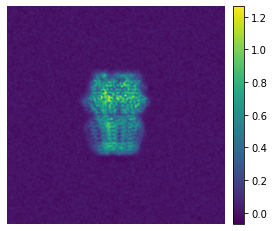

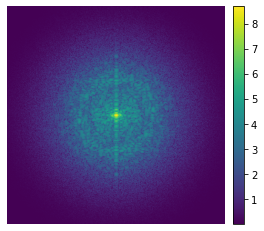

In [9]:
plt.figure(figsize=(5,4))
plt.plot(freq, fsc_y1y2, color='k', linestyle='-', linewidth=2, label='FSC')
plt.plot(freq, sfsc_adjusted, color=cmap_b[2], linewidth=2, label='SFSC')
plt.plot(freq, sfsc_whiten_adjusted, color=cmap_a[2], linewidth=2, label='SFSC whitened')
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('legend', fontsize=10)
plt.grid(which='major', linestyle='--')
plt.xlabel('spatial frequency 'r'(${\AA}^{-1}$)')
plt.title('Fourier shell correlation')
plt.legend(loc='lower left')
# plt.savefig('')
plt.show()

plt.figure(figsize=(5,4))
plt.imshow(y1)
plt.axis('off')
plt.colorbar(pad=0.03)
# plt.savefig('')
plt.show()

plt.figure(figsize=(5,4))
plt.imshow(fsc.log_abs(fsc.ft2(y1)))
plt.axis('off')
plt.colorbar(pad=0.03)
# plt.savefig('')
plt.show()

In [10]:
### Correction for slow decaying spectrum ###

np.random.seed(0)

snr = 10
B_signal = 10
B_noise = 0

y1, eps1 = fsc.generate_noisy_data(x, voxel, snr, B_signal, B_noise, return_noise=True)
y2, eps2 = fsc.generate_noisy_data(x, voxel, snr, B_signal, B_noise, return_noise=True)

fsc_y1y2 = fsc.two_image_frc(y1, y2, r)

sfsc = np.mean(fsc.single_image_frc(y1, r), axis=0)
sfsc_adjusted = 2*sfsc / (1 + sfsc)

y1_whiten = fsc.whitening_transform(y1, eps1, r)
y1_upsample = fsc.fourier_upsample(y1_whiten, 2)

sfsc_upsample = np.mean(fsc.single_image_frc(y1_upsample, r, whiten_upsample=True), axis=0)
# sfsc_upsample_adjusted = 2*sfsc_upsample / (1 + sfsc_upsample) # the variance correction is no longer necessary

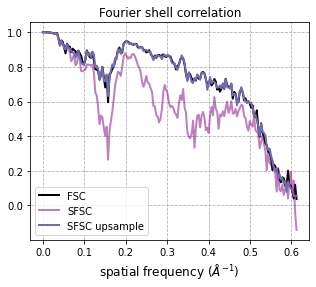

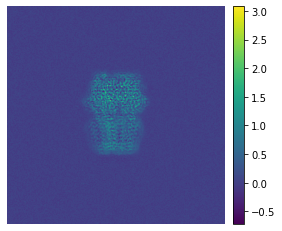

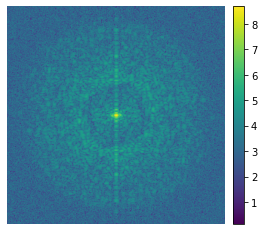

In [12]:
plt.figure(figsize=(5,4))
plt.plot(freq, fsc_y1y2, color='k', linestyle='-', linewidth=2, label='FSC')
plt.plot(freq, sfsc_adjusted, color='purple', alpha=0.5, linewidth=2, label='SFSC')
plt.plot(freq, sfsc_upsample, color=cmap_a[3], linewidth=2, label='SFSC upsample')
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('legend', fontsize=10)
plt.grid(which='major', linestyle='--')
plt.xlabel('spatial frequency 'r'(${\AA}^{-1}$)')
plt.title('Fourier shell correlation')
plt.legend(loc='lower left')
# plt.savefig('')
plt.show()

plt.figure(figsize=(5,4))
plt.imshow(y1)
plt.axis('off')
plt.colorbar(pad=0.03)
# plt.savefig('')
plt.show()

plt.figure(figsize=(5,4))
plt.imshow(fsc.log_abs(fsc.ft2(y1)))
plt.axis('off')
plt.colorbar(pad=0.03)
# plt.savefig('')
plt.show()